## ML per predirre valori azione dati altri indicatori quali: oro, VIX, etc

Cosa Include il Codice?
Nested Cross-Validation:
Previene overfitting e data leakage tipico dei time series 
Calcolo di RSI e MACD:
Indicatore di momentum e segnale di trading per migliorare le previsioni.
Grafico dei Risultati:
Visualizza il confronto tra predizioni e valori reali.
Inferenza:
Funzione per usare il modello con nuovi dati non normalizzati.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Definizione del periodo
fine_periodo = datetime.now() - timedelta(days=1)
# 1 anno di borsa equivale a 252 gg
inizio_periodo = fine_periodo - timedelta(days=252 * 20)

# Tick degli indicatori
tickers = {
    'Oro': 'GC=F',         # Future oro
    'Azioni': '^GSPC',     # Indice S&P 500
    'Bond': 'GLAG.L',      # ETF obbligazionario globale
    'Tassi': '^TNX',       # Rendimento Treasury 10Y
    'Inflazione': 'DBC',   # Commodity Index
    'VIX': '^VIX'          # Volatility Index
}

# Funzione per scaricare i dati
def scarica_dati():
    """Scarica i dati storici per gli indicatori chiave."""
    dati_allineati = []
    
    for nome, simbolo in tickers.items():
        try:
            df = yf.download(
                simbolo,
                start=inizio_periodo.strftime('%Y-%m-%d'),
                end=fine_periodo.strftime('%Y-%m-%d'),
                progress=False
            )
            if not df.empty and 'Close' in df.columns:
                df_temp = df['Close'].reset_index()
                df_temp.columns = ['Data', nome]
                print(f"Size indicatore {nome} è {len(df_temp)} ")
                dati_allineati.append(df_temp)
            else:
                print(f"Nessun dato disponibile per {nome} ({simbolo})")
        except Exception as e:
            print(f"Errore durante il download di {nome} ({simbolo}): {e}")
    
    if dati_allineati:
        df_finale = pd.DataFrame()
        for df in dati_allineati:
            if df_finale.empty:
                df_finale = df
            else:
                df_finale = pd.merge(df_finale, df, on='Data', how='inner')
        df_finale.set_index('Data', inplace=True)
        return df_finale
    else:
        raise ValueError("Nessun dato scaricato")

In [301]:
# Scarica i dati
df = scarica_dati()

Size indicatore Oro è 3525 
Size indicatore Azioni è 3527 
Size indicatore Bond è 1737 
Size indicatore Tassi è 3526 
Size indicatore Inflazione è 3527 
Size indicatore VIX è 3527 


In [128]:
# Funzioni per calcolare RSI e MACD
def calcola_rsi(df, colonna='Azioni', periodo=14):
    delta = df[colonna].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periodo, min_periods=1).mean()
    avg_loss = loss.rolling(window=periodo, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    return df

def calcola_macd(df, colonna='Azioni', slow=26, fast=12, signal=9):
    ema_fast = df[colonna].ewm(span=fast, adjust=False).mean()
    ema_slow = df[colonna].ewm(span=slow, adjust=False).mean()
    df['MACD'] = ema_fast - ema_slow
    df['Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

In [129]:

# Caricamento e preprocessamento dati
df = scarica_dati()
df = calcola_rsi(df)
df = calcola_macd(df)

Size indicatore Oro è 3524 
Size indicatore Azioni è 3526 
Size indicatore Bond è 1735 
Size indicatore Tassi è 3525 
Size indicatore Inflazione è 3526 
Size indicatore VIX è 3526 


## Utilizzo delle variabili lag ##

Le variabili lag sono spesso utilizzate in modelli di machine learning per:

Prevedere valori futuri: Catturare trend e stagionalità nelle serie temporali.
Identificare modelli di autocorrelazione: Analizzare come i valori passati di una variabile influenzano i valori futuri.
Creare nuove feature: Combinare variabili lag con altre variabili per creare nuove feature informative.

Esempio:

# Consideriamo un DataFrame con una colonna prezzo che rappresenta il prezzo di un prodotto nel tempo:

   tempo  prezzo
0      1     100
1      2     110
2      3     120
3      4     130
4      5     140

Se chiamiamo la funzione crea_lag_features con lags=2, il DataFrame risultante sarà:

   tempo  prezzo  prezzo_lag1  prezzo_lag2
1      2     110        100           NaN
2      3     120        110         100
3      4     130        120         110
4      5     140        130         120

Come puoi vedere, le nuove colonne prezzo_lag1 e prezzo_lag2 contengono i valori della colonna prezzo ritardati di 1 e 2 periodi, rispettivamente. I valori mancanti all'inizio del DataFrame vengono rimossi.



In [147]:
# Creazione delle variabili lag
def crea_lag_features(df, lags=5):
    df_lag = df.copy()
    for colonna in df.columns:
        for lag in range(1, lags + 1):
            df_lag[f'{colonna}_lag{lag}'] = df[colonna].shift(lag)
    return df_lag.dropna()

df_lag = crea_lag_features(df)

# Separazione variabili indipendenti e target
X = df_lag.drop(columns=['Azioni'])
y = df_lag['Azioni']

In [148]:
# Nested Cross-Validation
outer_cv = TimeSeriesSplit(n_splits=5)
parametri = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

rmse_scores = []

for train_idx, test_idx in outer_cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    inner_cv = TimeSeriesSplit(n_splits=3)
    modello = XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(modello, param_grid=parametri, cv=inner_cv, scoring='neg_mean_squared_error', verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE fold corrente: {rmse}")

rmse_medio = np.mean(rmse_scores)
print(f"RMSE medio finale: {rmse_medio}")




RMSE fold corrente: 217.07467540757202
RMSE fold corrente: 579.3446908350795
RMSE fold corrente: 247.2315393996047
RMSE fold corrente: 109.15628983970419
RMSE fold corrente: 700.5004691501314
RMSE medio finale: 370.6615329264184


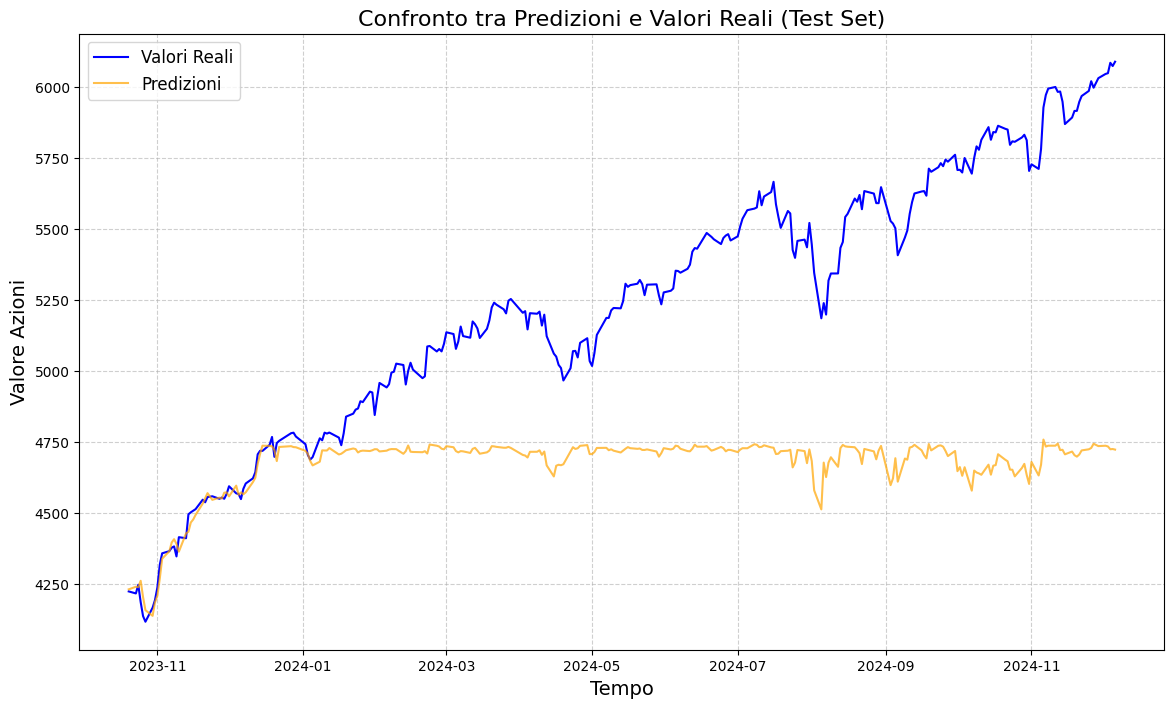

In [149]:
# Grafico dei risultati
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label="Valori Reali", color="blue")
plt.plot(y_test.index, y_pred, label="Predizioni", color="orange", alpha=0.7)
plt.title("Confronto tra Predizioni e Valori Reali (Test Set)", fontsize=16)
plt.xlabel("Tempo", fontsize=14)
plt.ylabel("Valore Azioni", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

proviamo ad applicare la bahesian optimization degli hyperparameter per vedere come va

In [ ]:
pip install scikit-optimize# Inferenza su nuovi dati
def predici_nuovi_valori(nuovi_dati, modello, scaler_X=None, scaler_y=None):
    if scaler_X:
        nuovi_dati = scaler_X.transform(nuovi_dati)
    predizioni = modello.predict(nuovi_dati)
    if scaler_y:
        predizioni = scaler_y.inverse_transform(predizioni)
    return predizioni



## Aternative ##

Quale scegliere?
Prophet: Se vuoi un approccio rapido con risultati interpretabili.
LSTM: Se hai molte variabili e vuoi catturare dipendenze non lineari.
ARIMA: Se la serie temporale è stazionaria e hai bisogno di un modello statistico robusto.


Per sfruttare al meglio la natura temporale dei tuoi dati, possiamo adottare modelli specifici per le serie temporali. Ti propongo una panoramica di tre approcci principali e come implementarli:

1. Prophet
Prophet è una libreria sviluppata da Facebook per l'analisi delle serie temporali, facile da configurare e molto efficace per catturare tendenze e stagionalità.

Vantaggi:
Adatto a serie temporali con trend e stagionalità.
Richiede meno tuning rispetto ad altri modelli.
Gestisce automaticamente i valori mancanti.

11:34:39 - cmdstanpy - INFO - Chain [1] start processing
11:34:40 - cmdstanpy - INFO - Chain [1] done processing


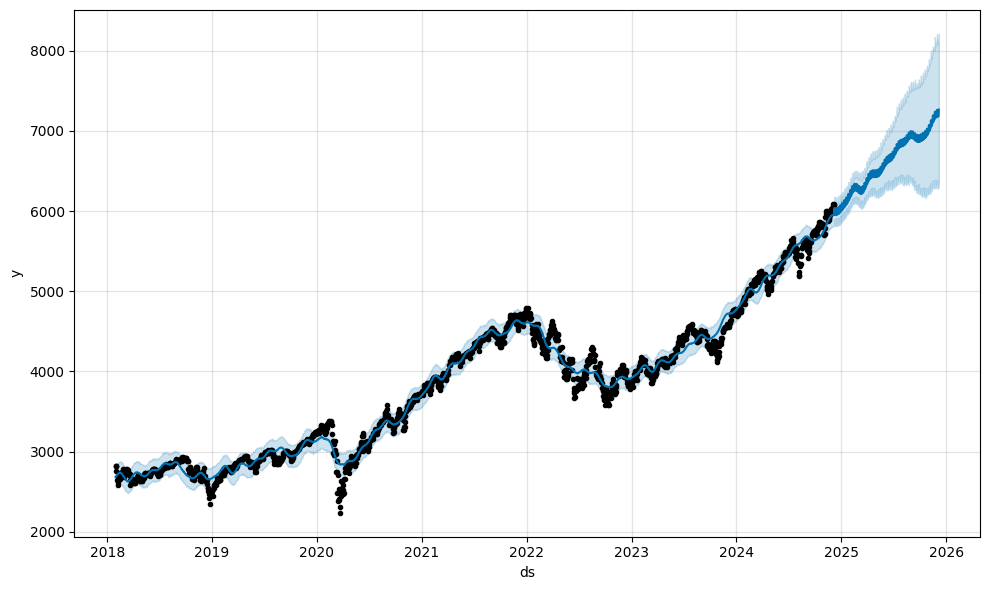

In [141]:
from prophet import Prophet

# Prepara i dati in formato accettato da Prophet
# la colonna data viene 
df_prophet = df[['Azioni']].reset_index()
# Prophet richiede sempre queste due colonne con questi nomi specifici.
df_prophet.columns = ['ds', 'y']

# Crea e addestra il modello
model = Prophet()
model.fit(df_prophet)

# Previsione su nuovi dati
future = model.make_future_dataframe(periods=365)  # Previsione per 1 anno
forecast = model.predict(future)

# Visualizzazione del risultato
model.plot(forecast)
plt.show()


Aggiungiamo anche gli altri indicatori ...

11:42:09 - cmdstanpy - INFO - Chain [1] start processing
11:42:10 - cmdstanpy - INFO - Chain [1] done processing


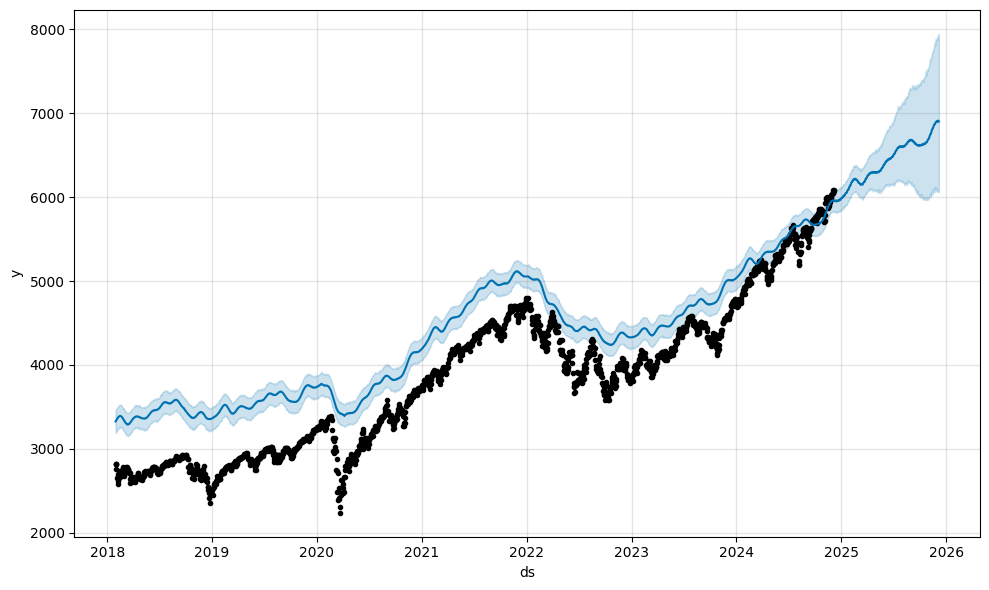

In [142]:
from prophet import Prophet
import pandas as pd

# Prepara il dataframe, includendo le colonne 'Oro' e 'Tassi' come regressori
df_prophet = df[['Azioni', 'Oro', 'Tassi']].reset_index()
df_prophet.columns = ['ds', 'y', 'Oro', 'Tassi']

# Crea un'istanza del modello Prophet
model = Prophet()

# Aggiungi regressori al modello
model.add_regressor('Oro')
model.add_regressor('Tassi')

# Addestra il modello con i dati
model.fit(df_prophet)

# Crea un dataframe con le date future per la previsione
future = model.make_future_dataframe(periods=365)

# Aggiungi anche i dati futuri per gli altri regressori
future['Oro'] = df_prophet['Oro'].iloc[-1]  # Prevedi con l'ultimo valore disponibile o usa una logica di previsione
future['Tassi'] = df_prophet['Tassi'].iloc[-1]  # Lo stesso vale per i tassi

# Calcola la previsione
forecast = model.predict(future)

# Visualizza il grafico
model.plot(forecast)
plt.show()


11:47:03 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing


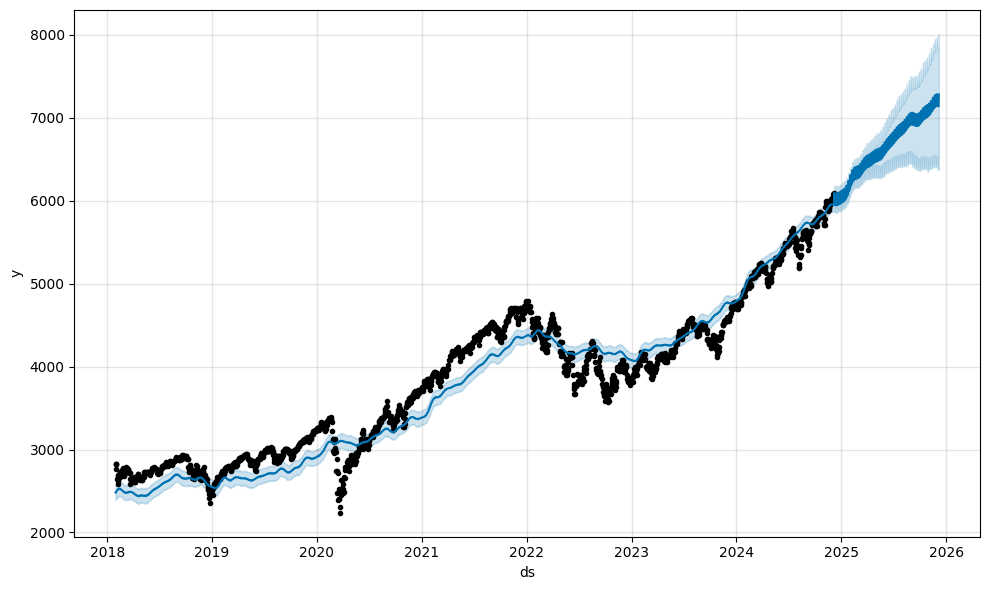

In [144]:

from prophet import Prophet
import pandas as pd

# Prepara il dataframe, includendo le colonne 'Oro' e 'Tassi' come regressori
df_prophet = df[['Azioni', 'Oro', 'Tassi','VIX','Inflazione','Bond']].reset_index()
df_prophet.columns = ['ds', 'y', 'Oro', 'Tassi','VIX','Inflazione','Bond']

# Crea un'istanza del modello Prophet
model = Prophet()

# Aggiungi regressori al modello
model.add_regressor('Oro')
model.add_regressor('Tassi')
model.add_regressor('VIX')
model.add_regressor('Inflazione')
model.add_regressor('Bond')

# Addestra il modello con i dati
model.fit(df_prophet)

# Crea un dataframe con le date future per la previsione
future = model.make_future_dataframe(periods=365)

# Aggiungi anche i dati futuri per gli altri regressori
future['Oro'] = df_prophet['Oro'].iloc[-1]  # Prevedi con l'ultimo valore disponibile o usa una logica di previsione
future['Tassi'] = df_prophet['Tassi'].iloc[-1]  # Lo stesso vale per i tassi
future['VIX'] = df_prophet['VIX'].iloc[-1]  # Lo stesso vale per i tassi
future['Inflazione'] = df_prophet['Inflazione'].iloc[-1]  # Lo stesso vale per i tassi
future['Bond'] = df_prophet['Bond'].iloc[-1]  # Lo stesso vale per i tassi


# Calcola la previsione
forecast = model.predict(future)

# Visualizza il grafico
model.plot(forecast)
plt.show()

2. LSTM (Long Short-Term Memory)
LSTM è una rete neurale ricorrente progettata per catturare le dipendenze a lungo termine nelle serie temporali.

Vantaggi:
Cattura dinamiche complesse non lineari.
Efficace per serie temporali con interazioni tra variabili.
Implementazione:
Richiede la conversione dei dati in sequenze.

C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0407 - val_loss: 0.0026
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.6645e-04 - val_loss: 6.0322e-04
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7410e-04 - val_loss: 5.4358e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7287e-04 - val_loss: 5.2530e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.9387e-04 - val_loss: 6.6230e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8471e-04 - val_loss: 4.8228e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.0832e-04 - val_loss: 4.4327e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7518e-04 - val_loss: 4.9106e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4081e-04 - val_loss: 6.8530e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7947e-04 - val_loss: 4.2539e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8947e-04 - val_

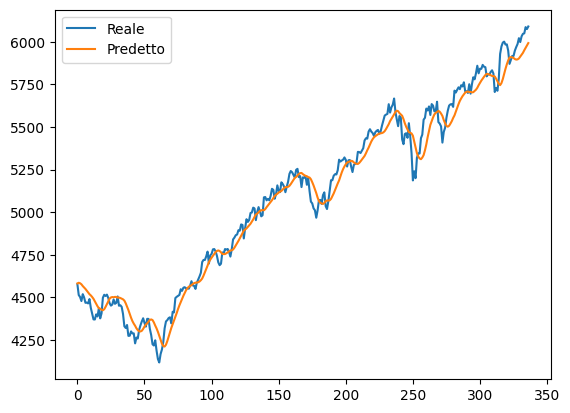

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Preprocessamento
scaler = MinMaxScaler()
dati_scalati = scaler.fit_transform(df[['Azioni']].values)

# Creazione delle sequenze
def crea_sequenze(data, lag=10):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i+lag])
        y.append(data[i+lag])
    return np.array(X), np.array(y)

lag = 10
X, y = crea_sequenze(dati_scalati, lag)

# Split dei dati
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Creazione del modello
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lag, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Previsione
y_pred = model.predict(X_test)
y_pred_inverso = scaler.inverse_transform(y_pred)

# Visualizzazione
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label="Reale")
plt.plot(y_pred_inverso, label="Predetto")
plt.legend()
plt.show()


predizione ad un anno

Size indicatore Oro è 3524 
Size indicatore Azioni è 3526 
Size indicatore Bond è 1735 
Size indicatore Tassi è 3525 
Size indicatore Inflazione è 3526 
Size indicatore VIX è 3526 
Epoch 1/20


C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0400 - val_loss: 0.0011
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.4067e-04 - val_loss: 0.0015
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.6123e-04 - val_loss: 0.0014
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.9394e-04 - val_loss: 8.0406e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.6663e-04 - val_loss: 4.0533e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.5973e-04 - val_loss: 4.8689e-04
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.7234e-04 - val_loss: 3.7461e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.1958e-04 - val_loss: 3.6850e-04
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.6174e-04 - val_loss: 4.0175e-04
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.9961e-04 - val_loss: 3.3920e-04
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.4370e-04 - val_loss: 7.3098e-04
Ep

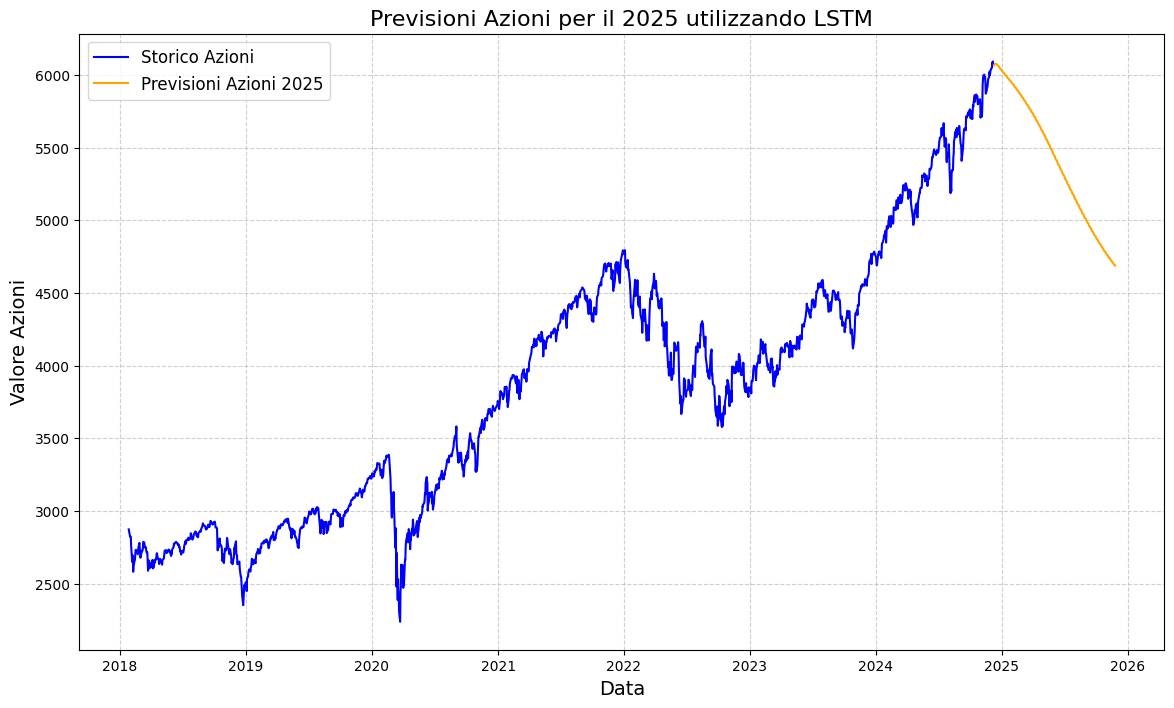

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Funzione per preparare i dati per LSTM (sequenze temporali)
def crea_sequenze(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])  # Prendi le ultime n_steps osservazioni
        y.append(data[i, 0])  # Il target è il prossimo valore
    return np.array(X), np.array(y)

# Carica i dati storici (ad esempio il valore delle azioni)
df = scarica_dati()  # Funzione scarica_dati che hai menzionato in precedenza
df = df[['Azioni']]  # Seleziona solo la colonna delle azioni

# Normalizza i dati
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df.values)

# Parametri
n_steps = 60  # Numero di giorni passati per predire il futuro
X, y = crea_sequenze(data_normalized, n_steps)

# Suddividi i dati in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Rimodella X per il modello LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Crea il modello LSTM
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Addestra il modello
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Fai previsioni per il futuro (2025)
# Creiamo un dataframe con le date future da prevedere
future_steps = 252  # Numero di giorni da predire (ad esempio, 252 giorni di trading in un anno)
last_sequence = data_normalized[-n_steps:]  # Ultime n_steps osservazioni come punto di partenza

# Prevediamo i valori futuri
predizioni_future = []
for _ in range(future_steps):
    predizione = model.predict(last_sequence.reshape(1, n_steps, 1))
    predizioni_future.append(predizione[0, 0])
    last_sequence = np.append(last_sequence[1:], predizione, axis=0)

# Inverti la normalizzazione per ottenere i valori originali
predizioni_future = scaler.inverse_transform(np.array(predizioni_future).reshape(-1, 1))

# Crea un dataframe con le previsioni per il 2025
date_future = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')  # 'B' per giorni lavorativi
df_future = pd.DataFrame(predizioni_future, index=date_future, columns=['Predizioni Azioni'])

# Visualizza le previsioni
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['Azioni'], label="Storico Azioni", color='blue')
plt.plot(df_future.index, df_future['Predizioni Azioni'], label="Previsioni Azioni 2025", color='orange')
plt.title("Previsioni Azioni per il 2025 utilizzando LSTM", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Valore Azioni", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


3. ARIMA (AutoRegressive Integrated Moving Average)
ARIMA è un modello statistico per catturare la componente autoregressiva, differenziata e media mobile.

Vantaggi:
Efficace per serie temporali stazionarie.
Buona interpretabilità.
Implementazione:
Richiede un'analisi preliminare della stazionarietà (ad esempio, test ADF).

C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\MauroBonacina\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Pred

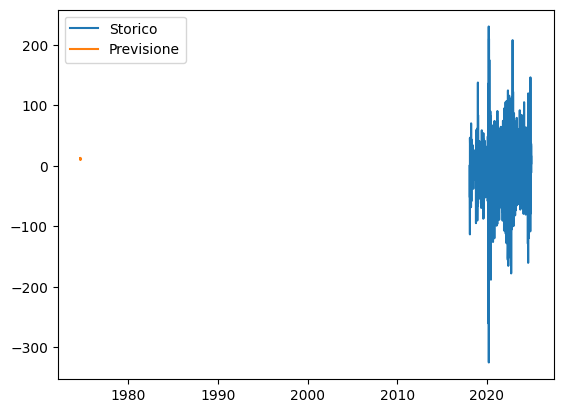

In [140]:
from statsmodels.tsa.arima.model import ARIMA

# Differenziazione per stazionarietà
df['Differenza'] = df['Azioni'] - df['Azioni'].shift(1)
df.dropna(inplace=True)

# Modello ARIMA
model = ARIMA(df['Differenza'], order=(5, 1, 0))
model_fit = model.fit()

# Previsione
forecast = model_fit.forecast(steps=30)  # Previsione per 30 giorni

# Visualizzazione
plt.plot(df['Differenza'], label="Storico")
plt.plot(range(len(df['Differenza']), len(df['Differenza']) + len(forecast)), forecast, label="Previsione")
plt.legend()
plt.show()
